# Notebook sur le tracking vidéo

Dans ce notebook nous allons voir comment on peut lire une vidéo, extraire les frames de la vidéo, faire de la détection (estimation de pose) et faire du tracking sur cette détection.

**Plan:**
1. Lecture de vidéo
2. Manipulation de frames
3. Estimation de pose
4. Utilisation des données

### 0. Import 

In [164]:
import cv2
import os
import subprocess
import json
import pandas as pd
import csv
import PIL.Image
from ipyfilechooser import FileChooser
import IPython.display
import ipywidgets 

### 1. Lecture de vidéo

Pour lire les vidéos et manipuler les images, nous allons utiliser la bibliothèque <a href='https://opencv.org/'>OpenCV<a>

In [134]:

#Selection de l'image

from ipyfilechooser import FileChooser
import os

# Create new FileChooser:
# Path: current directory
# File: test.txt
# Title: <b>FileChooser example</b>
# Show hidden files: no
# Use the default path and filename as selection: yes
# Only show folders: no
fdialog_vid = FileChooser(
    os.getcwd(),
    filename='test.txt',
    title='<b>FileChooser example</b>',
    show_hidden=False,
    select_default=True,
    show_only_dirs=False
)

display(fdialog_vid)

# Get the selected value
fdialog_vid.selected

# Callback example
def change_title(chooser):
    chooser.title = '<b>Sélection effectuée</b>'

# Register callback function
fdialog_vid.register_callback(change_title)

# Set or change the title
fdialog_vid.title = '<b>Selectionner une vidéo</b>'

# Show hidden files, change rows to 10, and hide folder icons
fdialog_vid.show_hidden = True
fdialog_vid.rows = 10
fdialog_vid.dir_icon = None

# Change folder icon to `os.sep` and append it to the folder name
fdialog_vid.dir_icon = os.sep
fdialog_vid.dir_icon_append = True



# Switch to folder-only mode
fdialog_vid.show_only_dirs = True

# Switch back to standard mode
fdialog_vid.show_only_dirs = False


# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fdialog_vid.filter_pattern = ['*.mp4', '*.avi']

# Change the default path and filename
fdialog_vid.default_path = os.path.abspath(os.getcwd())
fdialog_vid.default_filename = 'readme.md'

# Reset to defaults and clear the selected value
fdialog_vid.reset()




FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

In [135]:
#Lecture de la vidéo
video_name = fdialog_vid.selected

vidcap = cv2.VideoCapture(video_name)
    

### 2. Manipulation de frames

Pour la manipulation de frames, nous allons reprendre la bibliothèque <a href='https://opencv.org/'>OpenCV<a>

In [136]:
#Extraction des frames
if not os.path.isdir('output'):
    os.mkdir('output')
frame_path = os.path.join('output','frames')

if not os.path.isdir(frame_path):
    os.mkdir(frame_path)
    
success, image = vidcap.read()
i = 0
while success != False:
    #Lecture des frames
    success, image = vidcap.read()
    
    #Sauvegarder les frames
    if success:
        cv2.imwrite(os.path.join(frame_path, str(i) + ".jpg"), image)
    else:
        break
    
    i += 1




### 3. Estimation de la pose

Pour faire l'estimation de pose, nous allons utiliser <a href='https://github.com/CMU-Perceptual-Computing-Lab/openpose'>Openpose<a>

In [138]:
#Répertorier les frames dans le dossier où elles ont été sauvegardées

os.chdir(dossier_courant)
liste_frame = os.listdir(frame_path)

if not os.path.isdir(os.path.join('output','openpose_json')):
    os.mkdir(os.path.join('output','openpose_json'))
#Lancer Openpose sur les frames, Choisir où on enregistre les frames
chemin_sauvegarde = os.path.join('output','openpose_json')

path_openpose = "C:\\Users\\ReViVD\\Downloads\\openpose-1.7.0-binaries-win64-gpu-python3.7-flir-3d_recommended\\openpose"
dossier_courant = os.getcwd()
os.chdir(path_openpose)
if not os.path.isdir(chemin_sauvegarde):
    os.mkdir(chemin_sauvegarde)
subprocess.call("bin\\OpenPoseDemo.exe --video "+os.path.join(dossier_courant,video_name)+" --write_json "+os.path.join(dossier_courant,chemin_sauvegarde)+' --write_video '+os.path.join(dossier_courant,video_name.replace('.mp4','_openpose.avi'))+' --display 0')

#subprocess.call("bin\\OpenPoseDemo.exe --image_dir "+os.path.join(dossier_courant,'test')+" --write_images "+os.path.join(dossier_courant,'test2')+" --write_json "+os.path.join(dossier_courant,chemin_sauvegarde)+ ' --display 0')
os.chdir(dossier_courant)

    

### Keypoints Openpose

<img src="utils/openpose_keypoints.png" width=400 height=400 />

### 4. Utilisation des données

In [139]:
#Répertorier les json dans le dossier où elles ont été sauvegardées
liste_json_openpose = os.listdir(chemin_sauvegarde)

#Ouvrir les json et les récupérer les données
liste_toutes_valeurs = []
for le_json in liste_json_openpose:
        if '.json' in le_json: #test pour vérifier que c'est bien un fichier json
            data = pd.read_json(os.path.join(chemin_sauvegarde,le_json), lines=True)
            if len(data['people'])>0: #test pour vérifier qu'il y a bien au moins une personne détectée
                for i in range(len(data['people'][0])):
                    data_keypoints = data['people'][0][i]['pose_keypoints_2d']
                    for j in range(0,len(data_keypoints),3): #partie permettant de récupérer les coordonnées x, y et la confiance à chaque fois
                        liste_un_json = []
                        liste_un_json.append(int(le_json.split('_')[-2]))
                        liste_un_json.append(i)
                        liste_un_json.append(j//3)
                        liste_un_json.append(data_keypoints[j])
                        liste_un_json.append(data_keypoints[j+1])
                        liste_un_json.append(data_keypoints[j+2])
                        liste_toutes_valeurs.append(liste_un_json)

#Créer un fichier csv à l'aide des json créés par Openpose
chemin_csv_openpose = os.path.join('output','csv','openpose.csv') #chemin où on va enregistrer le csv contenant les informations openpose
if not os.path.isdir(os.path.split(chemin_csv_openpose)[0]):
    os.mkdir(os.path.split(chemin_csv_openpose)[0])
    

with open(chemin_csv_openpose,'w',newline='') as fichiercsv:
    writer=csv.writer(fichiercsv)
    writer.writerow(['frame','numero_pers','joint','x','y','confience'])
    for l in liste_toutes_valeurs:
        writer.writerow(l)





In [140]:
#Fonction permettant de tracer un rectangle à l'aide de 4 points
def draw_rect_video(frame, posA = (10, 50), posB = (20, 70), color = (255,0,0)):
    """draw a rectangle given 2 points"""
    #c = hex2rgb(colors[0])
    #color = (c[2], c[1], c[0])
    thickness = 6
    cv2.rectangle(frame, posA, posB, color, thickness)

    return


#Tracer des bounding box autour des joueurs à l'aide de l'estimation de pose
def bounding_box(num_frame,chemin_image,num_personne,chemin_csv,chemin_sauvegarder,afficher_image=True):
    if not os.path.isdir(chemin_sauvegarder):
        os.mkdir(chemin_sauvegarder)
    #Ouvir le fichier csv
    with open(chemin_csv, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) #permet de ne pas prendre l'en-tête
        max_x,max_y,min_x,min_y = -1,-1,-1,-1
        for row in reader:
            if ((int(row[0]) == num_frame) and (int(row[1]) == num_personne)):
                if max_x == -1:
                    max_x,max_y,min_x,min_y = float(row[3]),float(row[4]),float(row[3]),float(row[4])
                else:
                    if ((float(row[3]) > max_x)):
                        max_x = float(row[3])
                    if ((float(row[4]) > max_y)):
                        max_y = float(row[4])
                    if (((float(row[3]) < min_x) or (min_x == 0)) and (float(row[3]) != 0)):
                        min_x = float(row[3])
                    if (((float(row[4]) < min_y) or (min_y == 0)) and (float(row[4]) != 0)):
                        min_y = float(row[4])
    
    image = cv2.imread(chemin_image) #lire image
    draw_rect_video(image, (int(max_x),int(max_y)), (int(min_x),int(min_y))) #tracer rectangle
    
    cv2.imwrite(os.path.join(chemin_sauvegarder,str(num_frame)+'.jpg'),image) #enregistrer image avec box
    
    if afficher_image:
        IPython.display.display(Image(os.path.join(chemin_sauvegarder,str(num_frame)+'.jpg')))
            
#bounding_box(0,os.path.join('output','0.jpg'),0,'openpose.csv',os.path.join('output','frames_boxes'))
#Faire des premiers calculs de métrics (vitesses, distances de déplacements,...)
#Faire bounding box Couleur de la raquette



In [141]:
#tracer les box d'une personne sur tout un dossier
nom_dossier = os.path.join('output','frames')
liste_images = os.listdir(nom_dossier)
liste_images.sort()
liste_images.sort(key=len)
num_personne = 0
for i in range(len(liste_images)):
    bounding_box(i,os.path.join(nom_dossier,liste_images[i]),num_personne,os.path.join('output','csv','openpose.csv'),os.path.join('output','frames_boxes'),afficher_image=False)
    bounding_box(i,os.path.join(nom_dossier.replace('frames','frames_boxes'),liste_images[i]),1,os.path.join('output','csv','openpose.csv'),os.path.join('output','frames_boxes'),afficher_image=False)    
    bounding_box(i,os.path.join(nom_dossier.replace('frames','frames_boxes'),liste_images[i]),2,os.path.join('output','csv','openpose.csv'),os.path.join('output','frames_boxes'),afficher_image=False)    

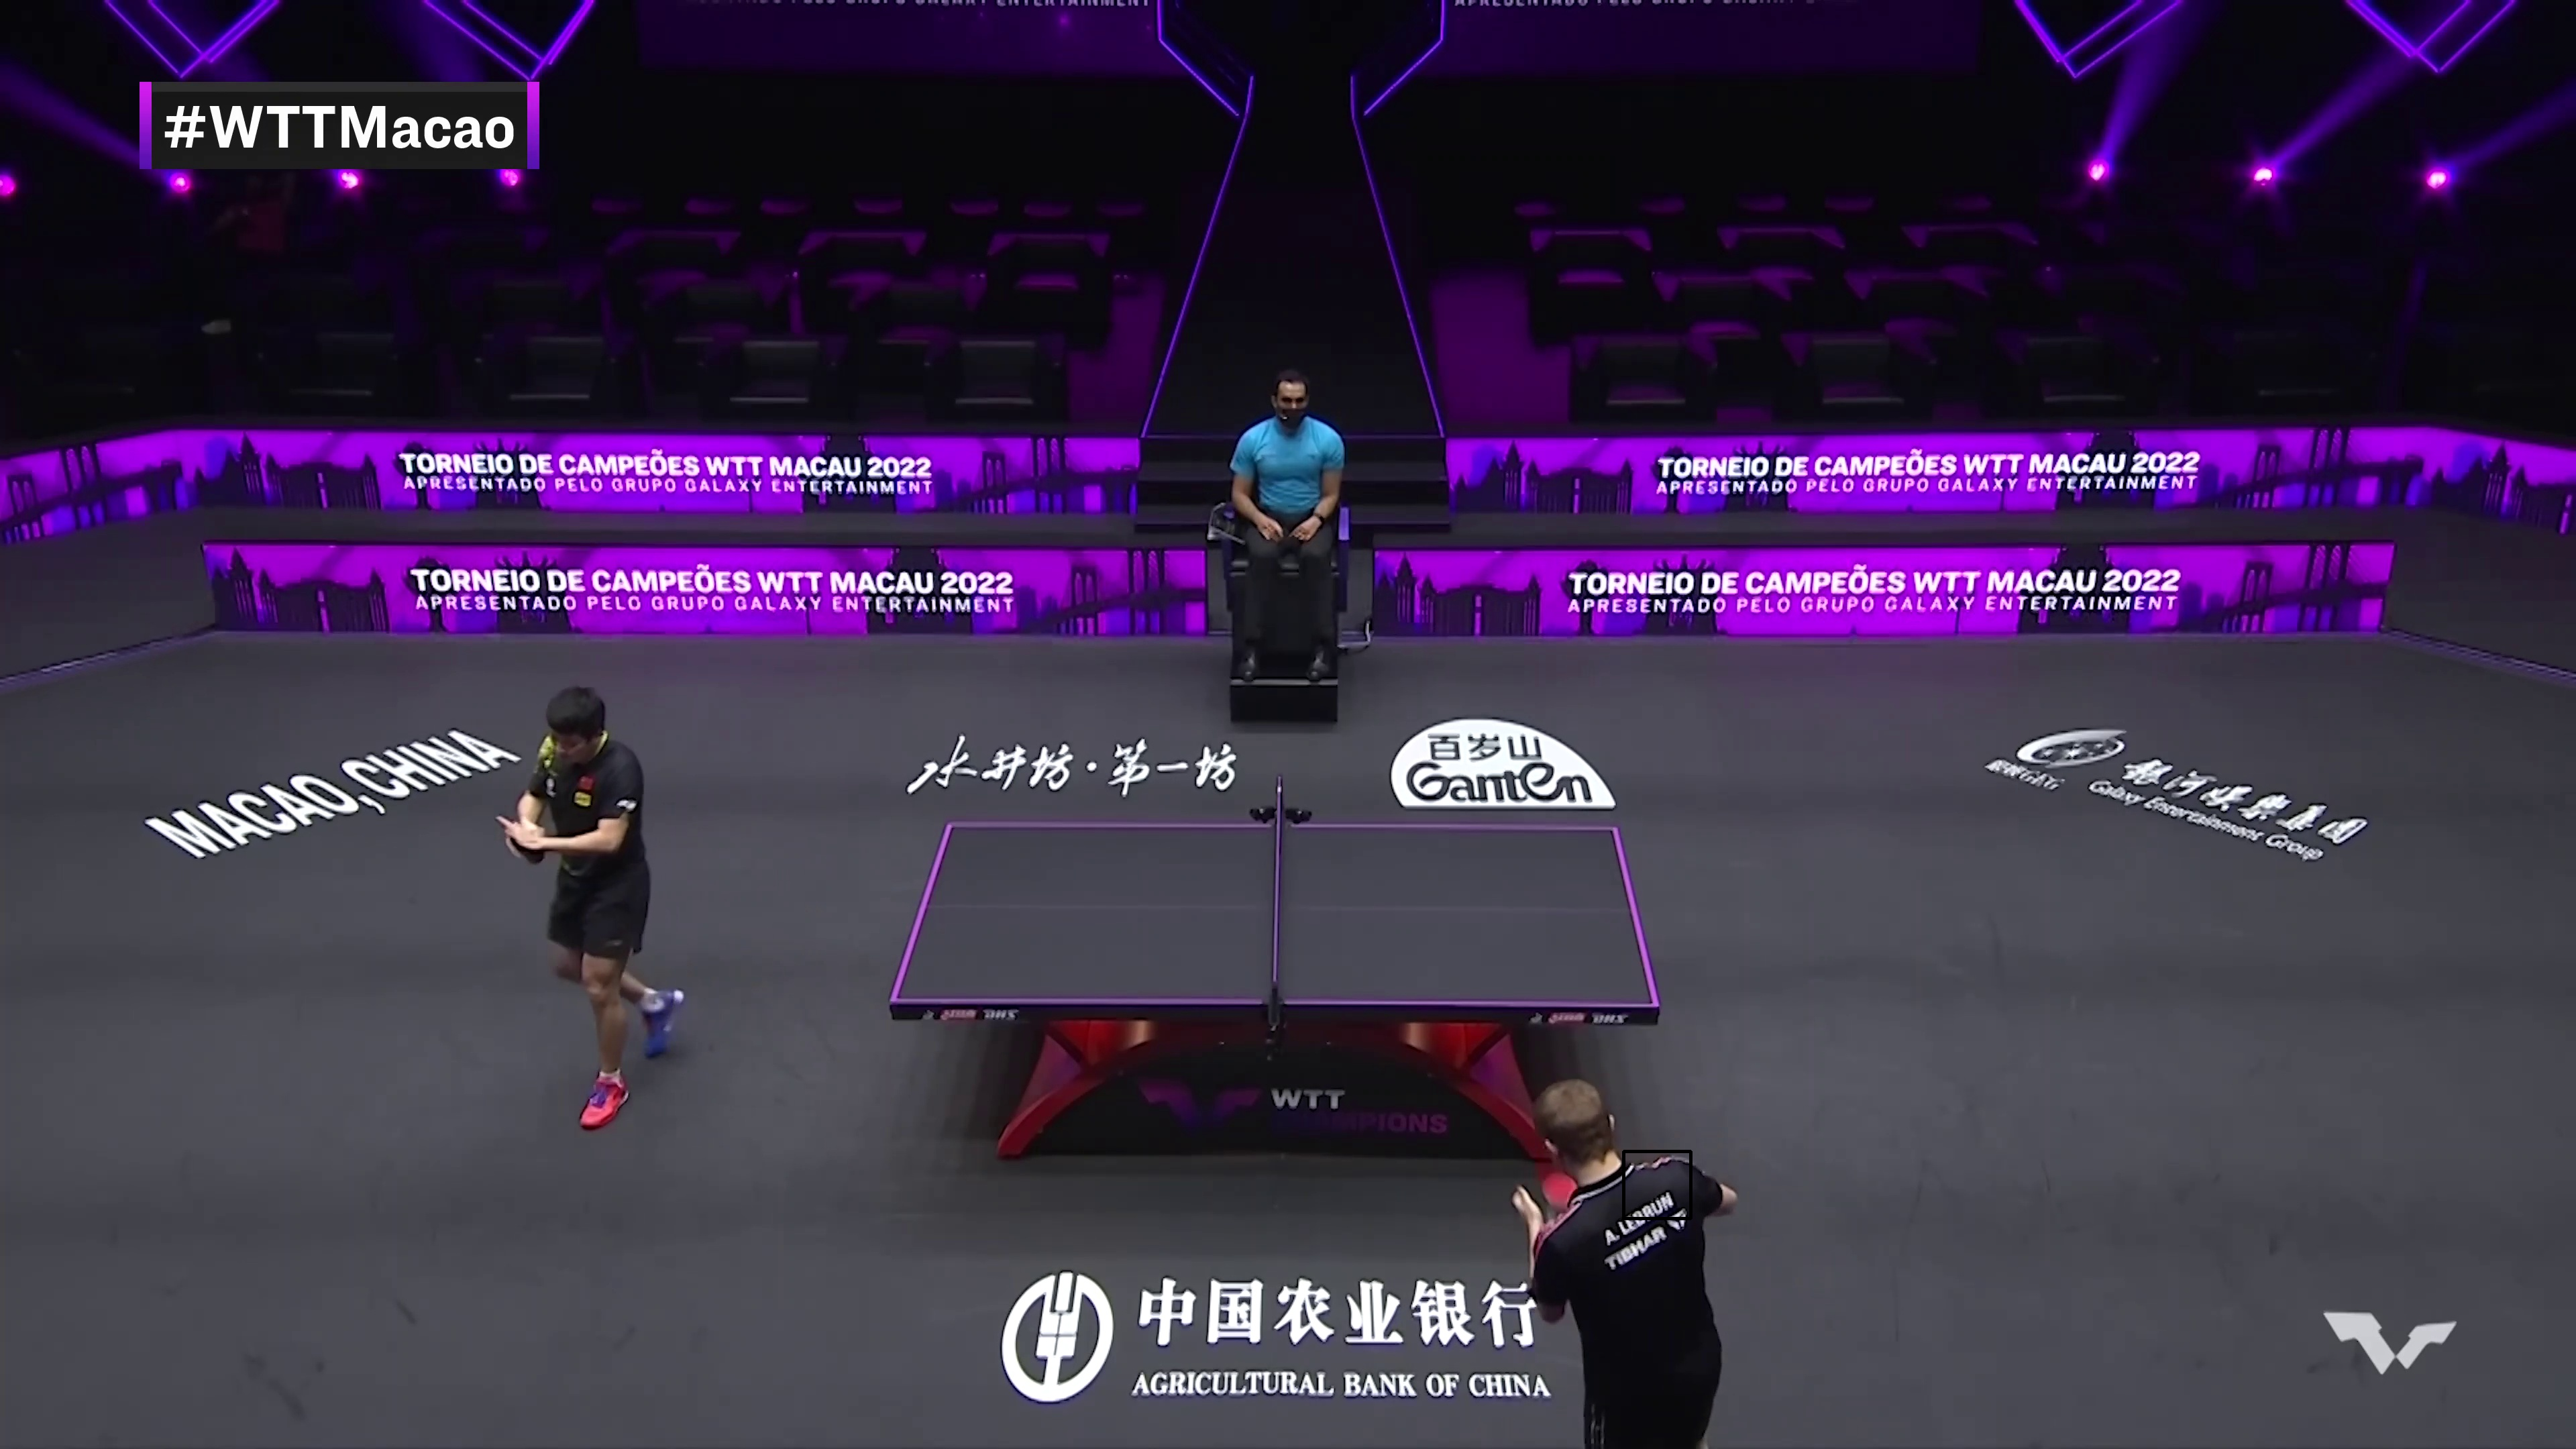

In [161]:
#Detecter la couleur de la raquette

def detect_couleur_raquette(chemin_image,point_main,point_coude):
    '''
        Fonction permettant de détecter la couleur de la raquette
        Entrée: le chemin de l'image, les coordonnées de la main droite, les coordonnées du coude droit
        Sortie: Trace sur l'image le rectangle contenant la raquette de la couleur détectée
    '''
    #dir = os.listdir('raquette/')
    facteur = 100
    
    frame = cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB)
    rouge = 0
    noir = 0
    if point_main[0] < point_coude[0]:
        for i in range(min(point_main[0],point_main[0]-facteur),max(point_main[0],point_main[0]-facteur)-3,4):
            for j in range(min(point_main[1]+facteur//2,point_main[1]-facteur//2),max(point_main[1]+facteur//2,point_main[1]-facteur//2)-3,4):
                if ((i <= frame.shape[0]) and (j <= frame.shape[1])):
                    if ((frame[i][j][2] > frame[i][j][0]+60) and (frame[i][j][2] > frame[i][j][1]+60)):
                        rouge += 1
                    elif((frame[i][j][0] < 55) and (frame[i][j][1] < 55) and (frame[i][j][2] < 55)):
                        #print('noir')
                        noir += 1
        if rouge > noir:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]-facteur,point_main[1]-facteur//2),(0,0,255), 3)
        else:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]-facteur,point_main[1]-facteur//2),(0,0,0), 3)
        #cv2.imwrite('raquette/raquette_'+str(len(dir))+'.jpg',frame[min(point_main[1]+facteur//2,point_main[1]-facteur//2):max(point_main[1]+facteur//2,point_main[1]-facteur//2),min(point_main[0],point_main[0]-facteur):max(point_main[0],point_main[0]-facteur)])
    else:
        for i in range(min(point_main[0],point_main[0]+facteur),max(point_main[0],point_main[0]+facteur)-3,4):
            for j in range(min(point_main[1]+facteur//2,point_main[1]-facteur//2),max(point_main[1]+facteur//2,point_main[1]-facteur//2)-3,4):
                if ((i <= frame.shape[0]) and (j <= frame.shape[1])):
                    if ((frame[i][j][2] > frame[i][j][0]+60) and (frame[i][j][2] > frame[i][j][1]+60)):
                        rouge += 1
                    elif((frame[i][j][0] < 55) and (frame[i][j][1] < 55) and (frame[i][j][2] < 55)):
                        #print('noir')
                        noir += 1
        if rouge > noir:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]+facteur,point_main[1]-facteur//2),(0,0,255), 3)
        else:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]+facteur,point_main[1]-facteur//2),(0,0,0), 3)
        #cv2.imwrite('raquette/raquette_'+str(len(dir))+'.jpg',frame[min(point_main[1]+facteur//2,point_main[1]-facteur//2):max(point_main[1]+facteur//2,point_main[1]-facteur//2),min(point_main[0],point_main[0]-facteur):max(point_main[0],point_main[0]-facteur)])

    IPython.display.display(PIL.Image.fromarray(frame))

    
#Appliquer sur une image
with open(os.path.join('output','csv','openpose.csv'), newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) #permet de ne pas prendre l'en-tête
    for row in reader:
        if ((int(row[0]) == 1) and (int(row[1]) == 0)):
            if (int(row[2]) == 3):#coude droit (6 pour le gauche)
                point_coude = [int(float(row[3])),int(float(row[4]))]
            if (int(row[2]) == 4):#main (7 pour le gauche)
                point_main = [int(float(row[3])),int(float(row[4]))]
detect_couleur_raquette(os.path.join('output','frames','29.jpg'),point_main,point_coude)


In [173]:
my_color = ipywidgets.widgets.Dropdown(
  options=['0' ,'1' ,'2' ,'3' ,'4' ,'5' ,'6' ,'7' ,'8' ,'9' ,'10' ,'11' ,'12' ,'13' ,'14' ,'15' ,'16' ,'17' ,'18' ,'19' ,'20' ,'21' ,'22' ,'23' ,'24'],
  value='0',
  description='Joint:',
  disabled=False,
  style={'description_width': 'initial'},
)

def on_color_change(change):
   """
   Change the plot color
   """
   walk.colors = [my_color.value]
     
my_color.observe(on_color_change, 'value')
display(my_color)

Dropdown(description='Joint:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '1…

In [174]:
my_color.value

'0'